原文参照：An Introduction to Virtual Adversarial Training
（https://divamgupta.com/unsupervised-learning/semi-supervised-learning/2019/05/31/introduction-to-virtual-adversarial-training.html）
代码参照：[https://gist.github.com/divamgupta]

In [1]:
from numpy.random import seed
seed(0)
from tensorflow import set_random_seed
set_random_seed(0)

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import keras
from keras.models import * 
from keras.layers import *
from sklearn.metrics import accuracy_score
import tensorflow as tf

Using TensorFlow backend.


# Make the datasets

In [4]:
from sklearn import datasets

circles =  datasets.make_circles(n_samples=1000 , noise=.05 , factor=0.3 ,random_state=3 )
circles_test =  datasets.make_circles(n_samples=10000 , noise=0 , factor=0.3 ,random_state=1 )

n_poionts = 8
inds = list (np.where(circles[1] == 0)[0][:n_poionts]) + list (np.where(circles[1] == 1)[0][:n_poionts])

X_train = circles[0][inds]
Y_train = circles[1][inds]
Y_train_cat = keras.utils.to_categorical( circles[1][inds] )

X_test = circles_test[0] 
Y_test = circles_test[1] 
Y_test_cat = keras.utils.to_categorical( circles_test[1]  )

n_classes = int( np.max(Y_train) + 1 )

## Plot the dataset

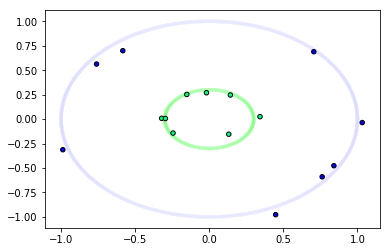

In [5]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=20 , cmap='winter'  , edgecolor='none' , alpha=0.005)
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=20 , cmap='winter'   , edgecolor='k')
plt.show()

In [6]:
def plot_model_predictions( m ):
    
    xx, yy = np.meshgrid(np.arange(-1.4, 1.4, 0.1),
                         np.arange(-1.8, 1.4, 0.1))

    Z = m.predict(np.c_[xx.ravel(), yy.ravel()]).argmax(-1)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='Greens'   )
    plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=20 , cmap='winter'  , edgecolor='none' , alpha=0.005)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=20 , cmap='winter'   , edgecolor='k')
    
    plt.show()

# Model without VAT

In [7]:
model = Sequential()
model.add( Dense(100 ,activation='relu' ,  input_shape=(2,)))
model.add( Dense(2 , activation='softmax' ))
model.compile( 'sgd' ,  'categorical_crossentropy'  ,  metrics=['accuracy'])

In [8]:
model.fit(  np.concatenate([X_train]*10000) , np.concatenate([Y_train_cat]*10000)  )

y_pred  = model.predict( X_test ).argmax(-1)
print("Test accruracy " , accuracy_score(Y_test , y_pred  ))

Epoch 1/1
160000/160000 [==============================] - 6s 37us/step - loss: 0.2050 - acc: 0.9870
Test accruracy  0.9059


### Plot the model outputs

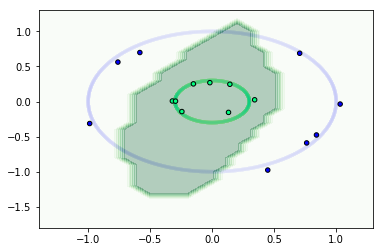

In [9]:
plot_model_predictions( model  )

# Model with VAT

In [10]:

def compute_kld(p_logit, q_logit):
    p = tf.nn.softmax(p_logit)
    q = tf.nn.softmax(q_logit)
    return tf.reduce_sum(p*(tf.log(p + 1e-16) - tf.log(q + 1e-16)), axis=1)


def make_unit_norm(x):
    return x/(tf.reshape(tf.sqrt(tf.reduce_sum(tf.pow(x, 2.0), axis=1)), [-1, 1]) + 1e-16)



In [11]:
network = Sequential()
network.add( Dense(100 ,activation='relu' ,  input_shape=(2,)))
network.add( Dense(2   ))

model_input = Input((2,))
p_logit = network( model_input )
p = Activation('softmax')( p_logit )

r = tf.random_normal(shape=tf.shape( model_input ))
r = make_unit_norm( r )
p_logit_r = network( model_input + 10*r  )

kl = tf.reduce_mean(compute_kld( p_logit , p_logit_r ))
grad_kl = tf.gradients( kl , [r ])[0]
r_vadv = tf.stop_gradient(grad_kl)
r_vadv = make_unit_norm( r_vadv )/3.0


p_logit_no_gradient = tf.stop_gradient(p_logit)
p_logit_r_adv = network( model_input  + r_vadv )
vat_loss =  tf.reduce_mean(compute_kld( p_logit_no_gradient, p_logit_r_adv ))


model_vat = Model(model_input , p )
model_vat.add_loss( vat_loss   )

model_vat.compile( 'sgd' ,  'categorical_crossentropy'  ,  metrics=['accuracy'])

model_vat.metrics_names.append('vat_loss')
model_vat.metrics_tensors.append( vat_loss )


In [12]:
model_vat.fit(  np.concatenate([X_train]*10000) , np.concatenate([Y_train_cat]*10000)  )

y_pred  = model_vat.predict( X_test ).argmax(-1)
print( "Test accruracy " , accuracy_score(Y_test , y_pred  ))

Epoch 1/1
160000/160000 [==============================] - 7s 43us/step - loss: 0.3167 - acc: 0.9776 - vat_loss: 0.0751
Test accruracy  1.0


### Plot the model outputs

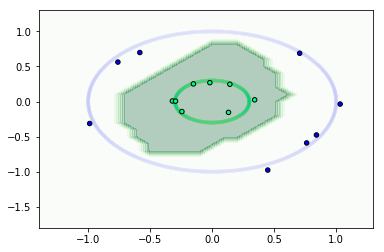

In [13]:
plot_model_predictions( model_vat  )
